## Drzewa decyzyjne | Lab 02 | Sikorski Jędrzej, Sem. VI, IST, Gr. nr 2, 118854

In [1]:
# Imports

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor as xgbr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import RandomizedSearchCV

### Zadanie #1

In [2]:
# --- Loading the dataset and splitting the labels and features ---

# Load the regression example data
data = fetch_california_housing(as_frame=True)

# Split data into labels and features
X = data.data
y = data.target

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [4]:
# --- Evaluating the XGBoost model for regression tasks ---

base_params = {
    "objective": "reg:squarederror",
    "random_state": 42,
    "eval_metric": "rmse",
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 6,
    "subsample": 1.0
}

# Run and test the model (manually) on defined test params
model_xgb_reg = xgbr(**base_params)

# Fitting the data
model_xgb_reg.fit(X_train, y_train)
y_pred = model_xgb_reg.predict(X_test)

In [5]:
# Testing the model accuracy
mse_base_xgb = mean_squared_error(y_pred, y_test)
r2_base_xgb = r2_score(y_pred, y_test)
print(f"Trained model accuracy\nMSE: {mse_base_xgb}\nR2_Score: {r2_base_xgb}")

Trained model accuracy
MSE: 0.26349450953988157
R2_Score: 0.7540730607126254


In [6]:
# --- Test different model parameters ---

test_params = {
    "n_estimators": [50, 150, 250, 500],
    "learning_rate": [0.0001, 0.001, 0.1, 1.0],
    "max_depth": [3, 12, 24, 48],
    "subsample": [0.1, 0.25, 0.5, 0.75]
}

In [7]:
# Define a manual (for-loop) model training and evaluation approach

def manual_train_test(model_class, base_params, test_params, X_train, X_test, y_train, y_test):
    results = []
    timer_start = time.time()

    for param_name, param_values in test_params.items():
        print(f"Testing parameter: {param_name}...")

        # Apply test params to the base params dict.
        for value in param_values:
            current_params = base_params.copy()
            current_params[param_name] = value

            try:
                model_instance = model_class(**current_params) # Unpack the updated params dict.
    
                # Measure the fitting time
                fit_start = time.time()
                model_instance.fit(X_train, y_train)
                fit_end = time.time()
                fitting_time = fit_end - fit_start
    
                # Model perf. evaluation
                y_pred = model_instance.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                print(f"{param_name} = {value}: MSE: {mse:.4f} | R2 Score: {r2:.4f} | Training time: {fitting_time:.2f}s")
    
                results.append({
                    "parameter": param_name,
                    "value": value,
                    "mse": mse,
                    "r2": r2,
                    "fit_time": fitting_time
                })
    
            except Exception as e:
                print(f"{param_name} = {value}: Failed. Error:t {e}")
                results.append({
                    "parameter": param_name,
                    "value": value,
                    "mse": np.nan, # Failure placeholder
                    "r2": np.nan, # Failure placeholder
                    "fit_time": np.nan # Failure placeholer
                })

    timer_end = time.time()
    testing_time_elapsed = timer_end - timer_start
    results_df = pd.DataFrame(results)

    return results_df, testing_time_elapsed

In [8]:
results_df_xgb, testing_time_elapsed_xgb = manual_train_test(xgbr, base_params, test_params, X_train, X_test, y_train, y_test)
print(f"\n--- Result dataframe ---\n{results_df_xgb}\n\nTesting time elapsed: {testing_time_elapsed_xgb:.2f}s")

Testing parameter: n_estimators...
n_estimators = 50: MSE: 0.2777 | R2 Score: 0.7909 | Training time: 0.10s
n_estimators = 150: MSE: 0.2599 | R2 Score: 0.8043 | Training time: 0.20s
n_estimators = 250: MSE: 0.2558 | R2 Score: 0.8074 | Training time: 0.34s
n_estimators = 500: MSE: 0.2553 | R2 Score: 0.8077 | Training time: 0.60s
Testing parameter: learning_rate...
learning_rate = 0.0001: MSE: 1.3109 | R2 Score: 0.0128 | Training time: 0.13s
learning_rate = 0.001: MSE: 1.1718 | R2 Score: 0.1176 | Training time: 0.14s
learning_rate = 0.1: MSE: 0.2635 | R2 Score: 0.8016 | Training time: 0.12s
learning_rate = 1.0: MSE: 0.4745 | R2 Score: 0.6427 | Training time: 0.13s
Testing parameter: max_depth...
max_depth = 3: MSE: 0.2914 | R2 Score: 0.7806 | Training time: 0.05s
max_depth = 12: MSE: 0.3104 | R2 Score: 0.7662 | Training time: 1.41s
max_depth = 24: MSE: 0.3300 | R2 Score: 0.7515 | Training time: 6.29s
max_depth = 48: MSE: 0.3302 | R2 Score: 0.7513 | Training time: 4.23s
Testing parameter:

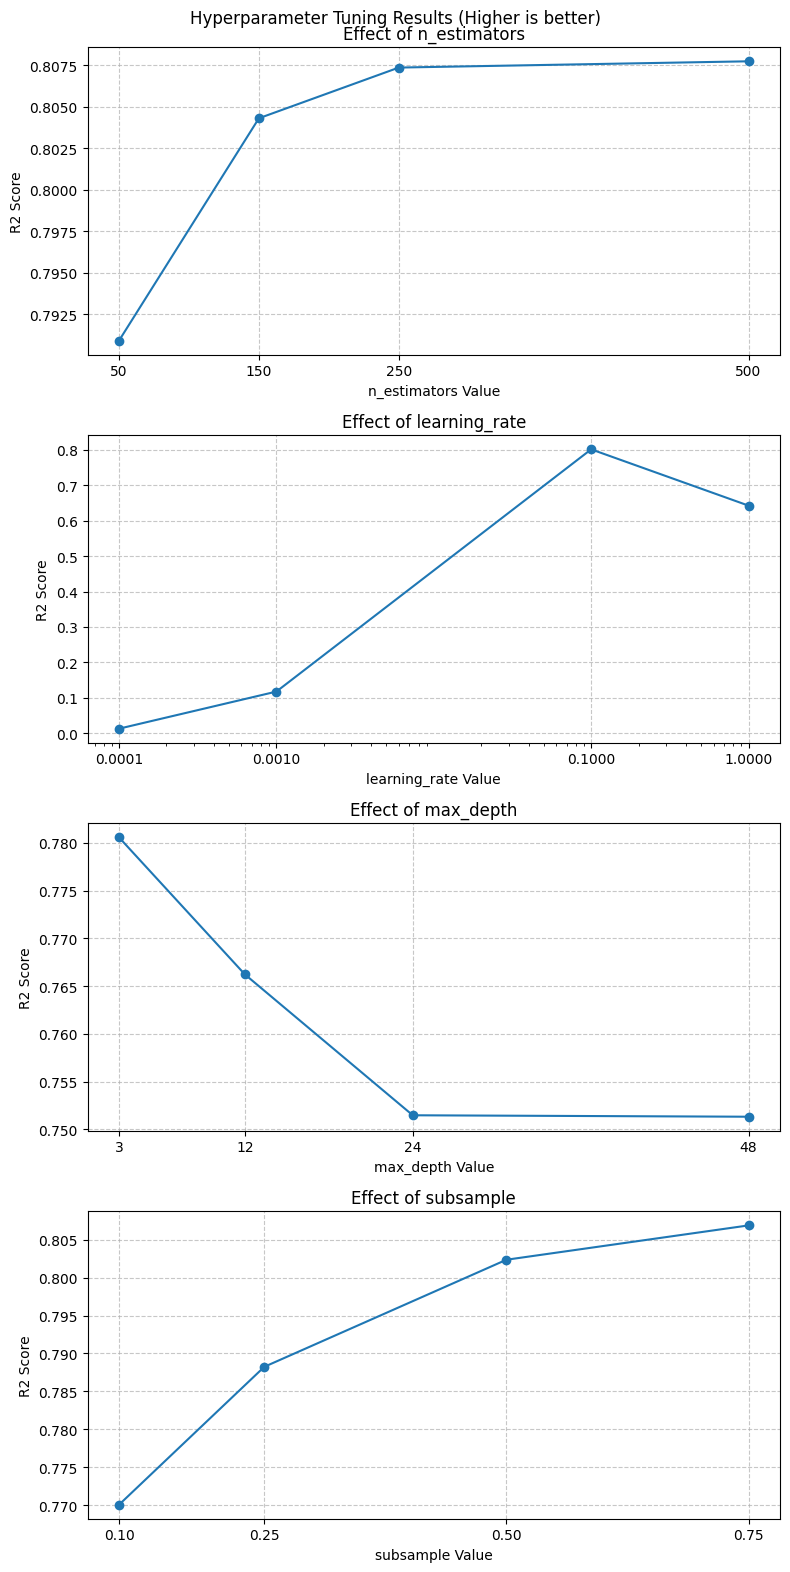

In [9]:
# Plot the results table for easier data visualization

# Group the parameters by name
unique_params = results_df_xgb["parameter"].unique()
n_params = len(unique_params)

score_col_to_plot = "r2"
score_label = "R2 Score"

fig, axes = plt.subplots(nrows=n_params, ncols=1,
                         figsize=(8, 4 * n_params),
                         sharex=False)

fig.suptitle(f"Hyperparameter Tuning Results (Higher is better)")

if n_params == 1:
    axes = [axes]

for i, param_name in enumerate(unique_params):
    ax = axes[i]

    subset_df = results_df_xgb[results_df_xgb["parameter"] == param_name].sort_values(by="value")

    ax.plot(subset_df["value"], subset_df[score_col_to_plot], marker="o", linestyle="-")

    ax.set_title(f"Effect of {param_name}")
    ax.set_xlabel(f"{param_name} Value")
    ax.set_ylabel(score_label)
    ax.grid(True, linestyle="--", alpha=0.7)

    if param_name == "learning_rate":
        ax.set_xscale("log")
        ax.set_xticks(subset_df["value"].unique())
        ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    elif len(subset_df["value"].unique()) <= 10:
        ax.set_xticks(subset_df["value"].unique())

plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

### Podsumowanie

#### Najlepsze znalezione przedziały wartości testowanych parametrów

- n_estimators: >= 250 (powyżej n_etimators == 250, poprawa wyniku była znikoma)
- learning_rate: 0.001 - 0.1
- max_depth: <= 3
- subsample: >= 0.75

Dla tych przedziałów wynik modelu był na najwyższym poziomie, stopniowo rósł w górę lub opadał, po przekroczeniu znalezionej wartości.

### Zadanie #2

In [10]:
# Load the dataset and define X, and y

data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

In [11]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Importing the LightGBM model

import lightgbm as lgb

In [13]:
base_params = {
    "objective": "regression",
    "random_state": 42,
    "metric": "rmse",
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 6,
    "subsample": 1.0
}

model_lgb_reg = lgb.LGBMRegressor(**base_params)

model_lgb_reg.fit(X_train, y_train)
y_pred = model_lgb_reg.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 2.071947


In [14]:
mse_base_lgb = mean_squared_error(y_pred, y_test)
r2_base_lgb = r2_score(y_pred, y_test)
print(f"Trained model accuracy (LightGBM)\nMSE: {mse_base_lgb}\nR2_Score: {r2_base_lgb}")

Trained model accuracy (LightGBM)
MSE: 0.22458122312911416
R2_Score: 0.7898496692221495


In [15]:
# Skip adding test params -- I'll use the same param dictionary as for the XGBoost model before, to properly compare the time, and score differences

In [16]:
results_df_lgb, testing_time_elapsed_lgb = manual_train_test(lgb.LGBMRegressor, base_params, test_params, X_train, X_test, y_train, y_test)
print(f"\n--- Result dataframe ---\n{results_df_lgb}\n\nTesting time elapsed: {testing_time_elapsed_lgb:.2f}s")

Testing parameter: n_estimators...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 2.071947
n_estimators = 50: MSE: 0.2567 | R2 Score: 0.8041 | Training time: 0.07s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 2.071947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

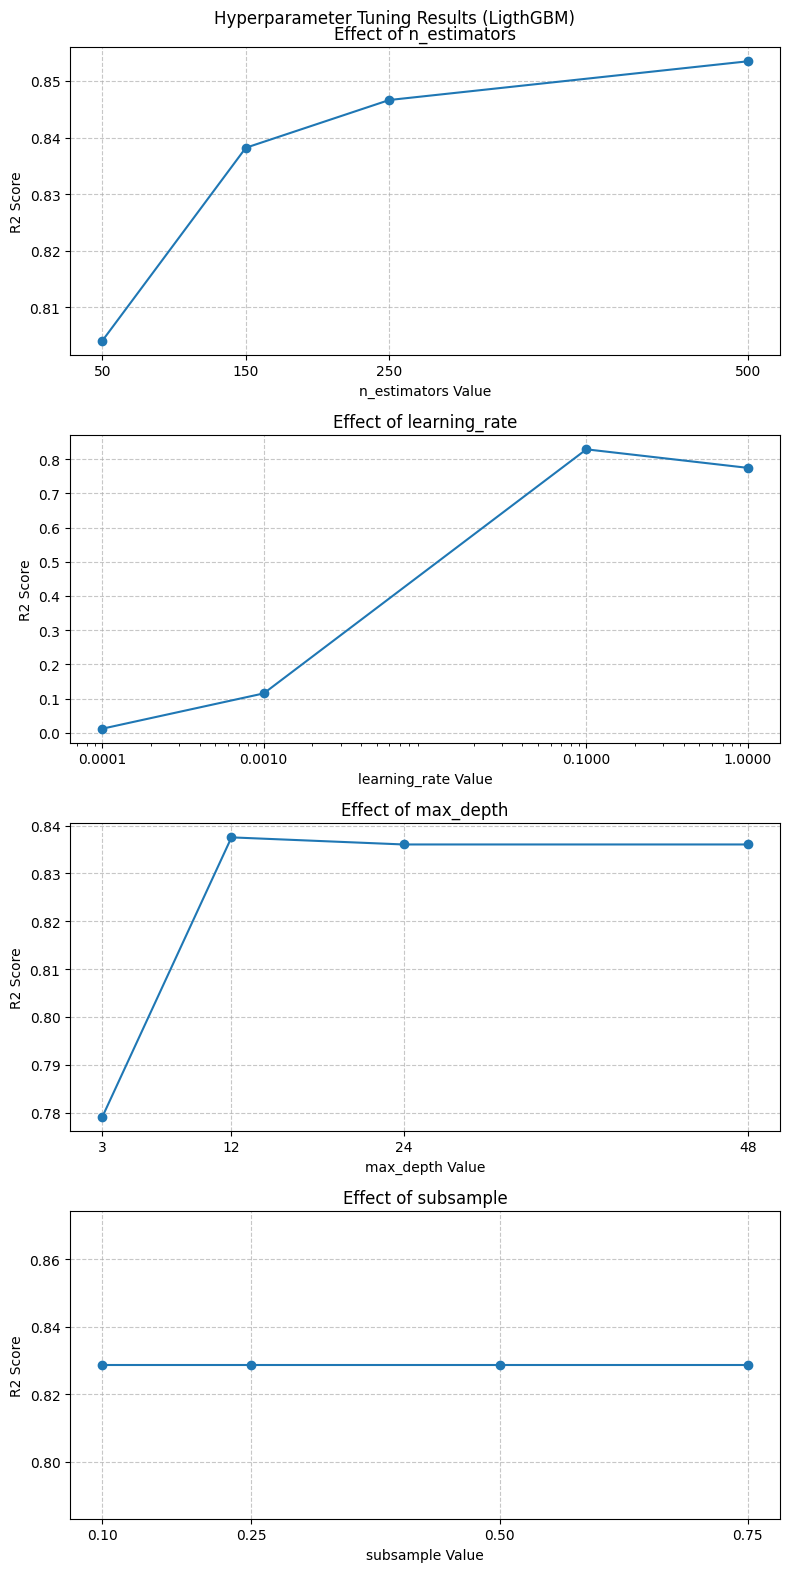

In [17]:
# Plot the results table for better data visualization

# Group the parameters by name
unique_params = results_df_lgb["parameter"].unique()
n_params = len(unique_params)

score_col_to_plot = "r2"
score_label = "R2 Score"

fig, axes = plt.subplots(nrows=n_params, ncols=1,
                         figsize=(8, 4 * n_params),
                         sharex=False)

fig.suptitle("Hyperparameter Tuning Results (LigthGBM)")

for i, param_name in enumerate(unique_params):
    ax = axes[i]

    subset_df = results_df_lgb[results_df_lgb["parameter"] == param_name].sort_values(by="value")

    ax.plot(subset_df["value"], subset_df[score_col_to_plot], marker="o", linestyle="-")

    ax.set_title(f"Effect of {param_name}")
    ax.set_xlabel(f"{param_name} Value")
    ax.set_ylabel(score_label)
    ax.grid(True, linestyle="--", alpha=0.7)

    if param_name == "learning_rate":
        ax.set_xscale("log")
        ax.set_xticks(subset_df["value"].unique())
        ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    elif len(subset_df["value"].unique()) <= 10:
        ax.set_xticks(subset_df["value"].unique())

plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

### Porównanie

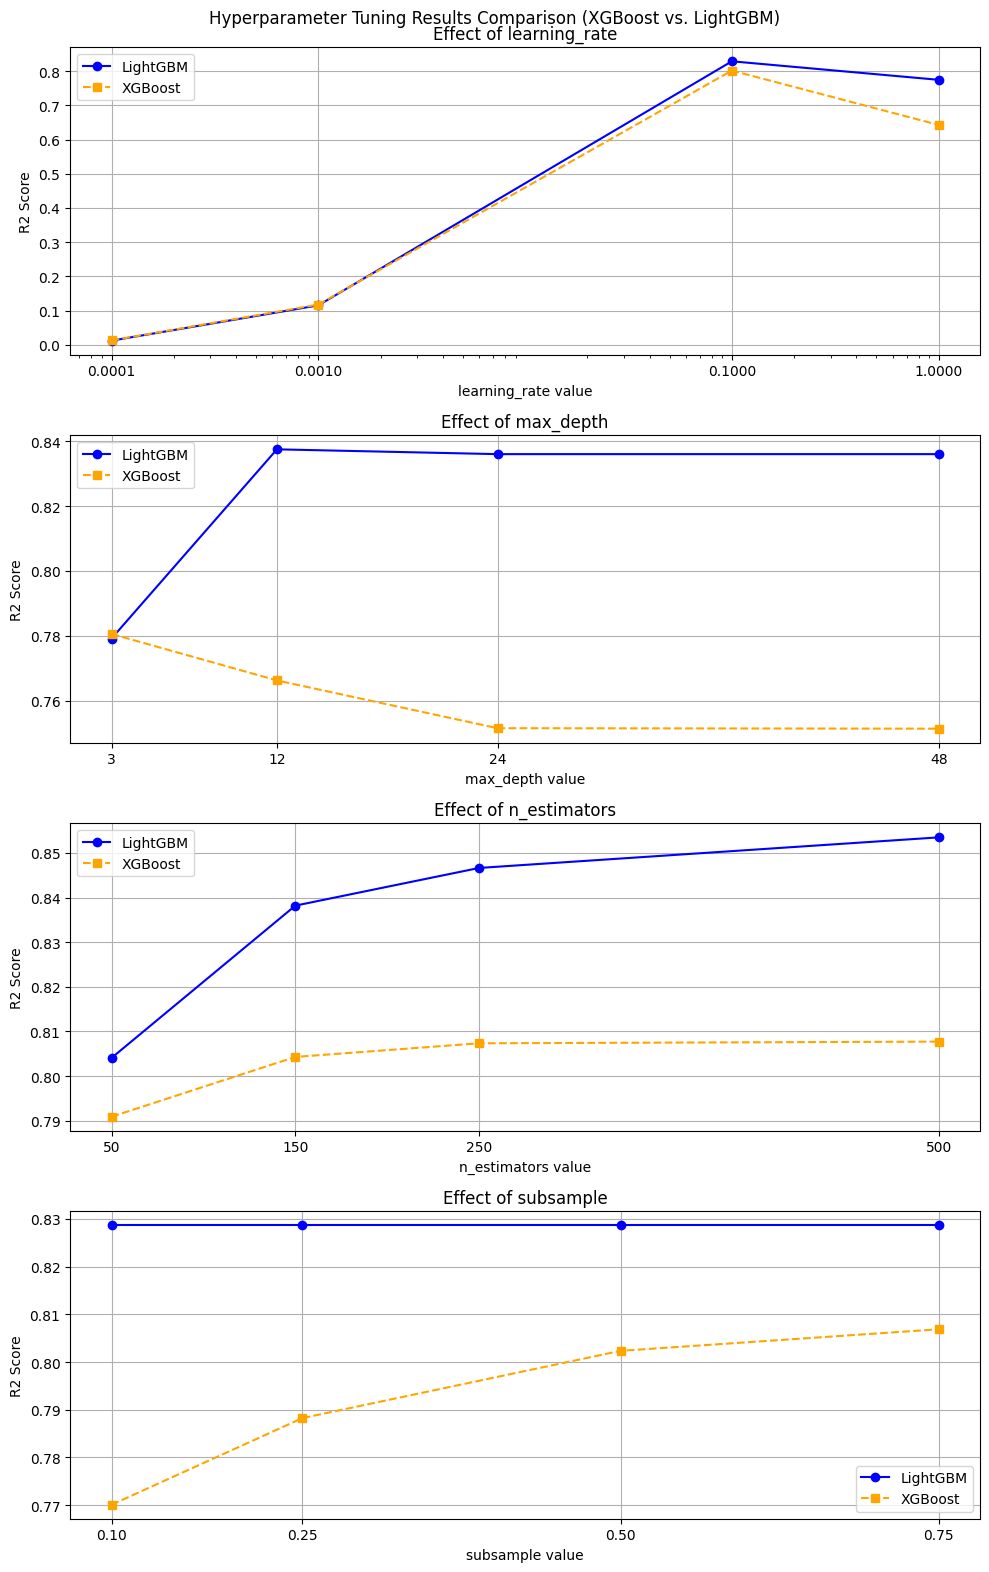

In [18]:
unique_params_union = np.union1d(results_df_xgb["parameter"].unique(), results_df_lgb["parameter"].unique())
n_params = len(unique_params_union)

score_col_to_plot = "r2"
score_label = "R2 Score"

fig, axes = plt.subplots(nrows=n_params, ncols=1,
                         figsize=(10, 4 * n_params),
                         sharex=False)

fig.suptitle("Hyperparameter Tuning Results Comparison (XGBoost vs. LightGBM)")

for i, param_name in enumerate(unique_params_union):
    ax = axes[i]

    subset_df_lgb = results_df_lgb[results_df_lgb["parameter"] == param_name].sort_values(by="value")
    ax.plot(subset_df_lgb["value"], subset_df_lgb[score_col_to_plot], marker="o", linestyle="-", color="blue", label="LightGBM")

    subset_df_xgb = results_df_xgb[results_df_xgb["parameter"] == param_name].sort_values(by="value")
    ax.plot(subset_df_xgb["value"], subset_df_xgb[score_col_to_plot], marker="s", linestyle="--", color="orange", label="XGBoost")

    ax.set_title(f"Effect of {param_name}")
    ax.set_xlabel(f"{param_name} value")
    ax.set_ylabel(score_label)
    ax.grid(True)
    ax.legend()

    if param_name == "learning_rate":
        ax.set_xscale("log")
        all_unique_values = np.union1d(
            subset_df_lgb["value"].unique(), 
            subset_df_xgb["value"].unique()
        )
        ax.set_xticks(all_unique_values)
        ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

    elif len(np.union1d(
        subset_df_lgb["value"].unique(), 
        subset_df_xgb["value"].unique()
    )) <= 10:
        all_unique_values = np.union1d(
        subset_df_lgb["value"].unique(), 
        subset_df_xgb["value"].unique()
        )
        ax.set_xticks(all_unique_values)

plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

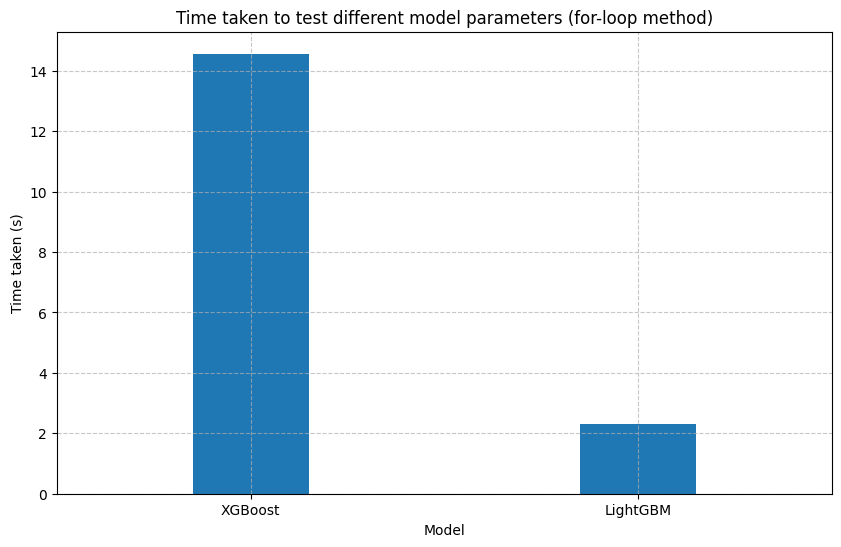

In [19]:
plt.figure(figsize=(10, 6))

plt.bar(["XGBoost", "LightGBM"], [testing_time_elapsed_xgb, testing_time_elapsed_lgb], width=0.3)

plt.title("Time taken to test different model parameters (for-loop method)")
plt.xlabel("Model")
plt.ylabel("Time taken (s)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(-0.5, 1.5)
plt.show()

- Algorytm LightGBM uzyskał lepsze wyniki R2 Score od algorytmu XGBoost
- LigthGBM jest bardziej czuły na tuning hiperparametrów -- po zmianie parametrów wynik rośnie lub maleje w szybszym tempie. Wyjątkiem było subsample, którego zmiany wartości nie wniosły zmian w wyniku R2 modelu (zadziało się tak, ponieważ domyślnie LightGBM ustawia parametr bagging_freq na 0, co skutkuje brakiem zmian przy zmianie wartości subsample).
- LightGBM jest szybszym algorytmem od XGBoost (oraz wymaga mniej zasobów, co wynika z dokumentacji i założeń algorytmu)

### Zadanie #3

In [20]:
# Define the model (XGBoost)

base_params = {
    "objective": "reg:squarederror",
    "random_state": 42,
    "eval_metric": "rmse",
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 6,
    "subsample": 1.0
}

model_xgb_reg = xgbr(**base_params)

# Define the testing params
param_grid = {
    "n_estimators": [50, 150, 250, 500],
    "learning_rate": [0.0001, 0.001, 0.1, 1.0],
    "max_depth": [3, 12, 24, 48],
    "subsample": [0.1, 0.25, 0.5, 0.75]
}

rcv = RandomizedSearchCV(model_xgb_reg, param_grid, cv=3, n_jobs=-1) # Use 3-fold CV, use all cores

rcv_search_time_start = time.time()
rcv.fit(X_train, y_train)
rcv_search_time_end = time.time()
rcv_search_time = rcv_search_time_end - rcv_search_time_start

print(f"Best found params from RandomizedSearchCV: {rcv.best_params_}")

rcv_pred = rcv.predict(X_test)

mse_best_xgb = mean_squared_error(rcv_pred, y_test)
r2_best_xgb = r2_score(rcv_pred, y_test)

print(f"MSE: {mse_best_xgb}")
print(f"R2 Score: {r2_best_xgb}")

Best found params from RandomizedSearchCV: {'subsample': 0.25, 'n_estimators': 500, 'max_depth': 12, 'learning_rate': 0.1}
MSE: 0.2387831343355524
R2 Score: 0.7854541691944483


### Porównanie


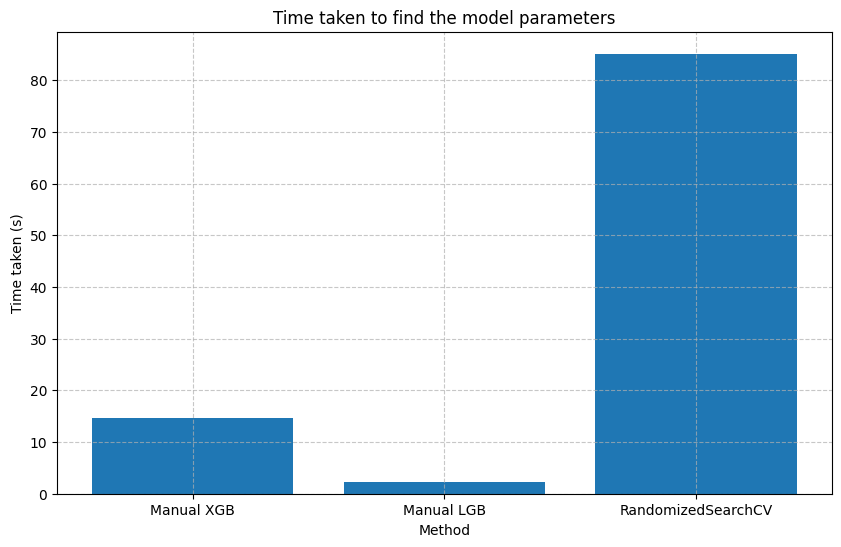

In [21]:
# Plot bar chart showing the time distribution for finding params (manual for-loops vs. RandomizedSearchCV comparison)

# Resize the chart
plt.figure(figsize=(10, 6))

# Plot the (X) model testing methods / (Y) time taken to evaluate the parameters
plt.bar(["Manual XGB", "Manual LGB", "RandomizedSearchCV"], [testing_time_elapsed_xgb, testing_time_elapsed_lgb, rcv_search_time])

# Add plot labels
plt.title("Time taken to find the model parameters")
plt.xlabel("Method")
plt.ylabel("Time taken (s)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

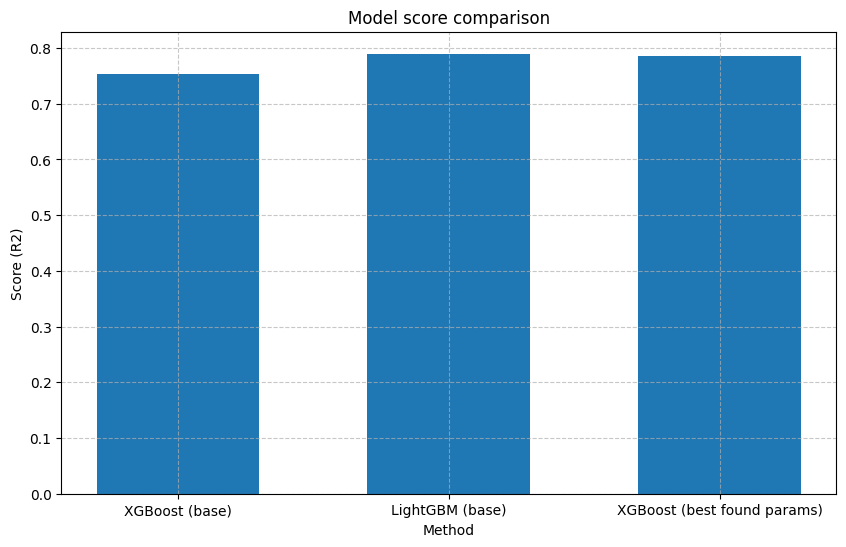

In [22]:
# Plot bar chart showing the comparison between the base param score vs. the best found params returned by RandomizedSearchCV

# Resize the chart
plt.figure(figsize=(10, 6))

# Plot the (X) model testing methods / (Y) model score (R2)
plt.bar(["XGBoost (base)", "LightGBM (base)", "XGBoost (best found params)"], [r2_base_xgb, r2_base_lgb, r2_best_xgb], width=0.6)

# Add plot labels
plt.title("Model score comparison")
plt.xlabel("Method")
plt.ylabel("Score (R2)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()